# Yield prediction model comparison: OLS, Ridge, Random Forest, Ridge+PCA

This notebook trains and compares four models to predict **Mean_Yield**:

1. **OLS** (ordinary least squares)
2. **Ridge** (L2-regularized linear regression)
3. **Random Forest** (non-linear ensemble)
4. **Ridge + PCA** (principal components on numeric climate features + ridge)

The goal is to make the comparison **easy to visualize** with:
- a compact metrics table
- bar charts (R², RMSE)
- predicted vs actual plots for each model

> Notes
> - This notebook assumes your data file is named `yields_weather_by_crop.csv` and exists in a `prepared/` folder (or nearby).
> - It automatically detects categorical columns (like `Municipality`, `Crop`) and one-hot encodes them.
> - It applies scaling only where needed (linear models).


In [1]:
# === Imports ===
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [2]:
# === Load data ===
data_path = "./prepared/yields_weather_by_crop.csv"

df = pd.read_csv(data_path)
print("Shape:", df.shape)
df.head()


Shape: (4864, 100)


,Year,Municipality,Crop,Mean_Yield,05_Q1_CDD,05_Q2_CDD,06_Q1_CDD,06_Q2_CDD,07_Q1_CDD,07_Q2_CDD,...,06_Q1_Total Snow,06_Q2_Total Snow,07_Q1_Total Snow,07_Q2_Total Snow,08_Q1_Total Snow,08_Q2_Total Snow,09_Q1_Total Snow,09_Q2_Total Snow,10_Q1_Total Snow,10_Q2_Total Snow
0,1996,ALEXANDER,ARGENTINE CANOLA,0.728428,0.0,1.406025,32.701730,41.166500,31.423716,15.575997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1996,ALEXANDER,OATS,1.215000,0.0,1.406025,32.701730,41.166500,31.423716,15.575997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1996,ALONSA,ALFALFA/GRASS MIX.,1.609253,0.0,2.014729,37.197368,35.920028,39.128350,18.739317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1996,ARGYLE,ALFALFA,2.080575,0.0,0.152813,24.440870,34.404783,27.131971,17.745561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1996,ARGYLE,ALFALFA/GRASS MIX.,1.658000,0.0,0.152813,24.440870,34.404783,27.131971,17.745561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# === Split features/target ===
TARGET = "Mean_Yield"

y = df[TARGET]
X = df.drop(columns=[TARGET])

# Identify categorical vs numeric
cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"Numeric columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")
print("Categorical columns:", cat_cols)


Numeric columns: 97
Categorical columns: 2
Categorical columns: ['Municipality', 'Crop']


In [4]:
# === Train/test split ===
# If you prefer time-aware splitting (e.g., by Year), adapt this section.

RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (3891, 99) Test size: (973, 99)


## Preprocessing

We use a **ColumnTransformer**:

- **Numeric**: median imputation + (optionally) scaling
- **Categorical**: most-frequent imputation + one-hot encoding

Scaling is applied for linear models (OLS/Ridge/Ridge+PCA). Random Forest does not need scaling.


In [5]:
# === Preprocessing blocks ===

numeric_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="most_frequent")

categorical_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess_for_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("impute", numeric_imputer), ("scale", StandardScaler())]), num_cols),
        ("cat", Pipeline([("impute", categorical_imputer), ("onehot", categorical_encoder)]), cat_cols),
    ],
    remainder="drop",
)

preprocess_for_rf = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("impute", numeric_imputer)]), num_cols),
        ("cat", Pipeline([("impute", categorical_imputer), ("onehot", categorical_encoder)]), cat_cols),
    ],
    remainder="drop",
)


## Models

- **OLS**: `LinearRegression()`
- **Ridge**: `Ridge(alpha=...)`
- **Random Forest**: `RandomForestRegressor(...)`
- **Ridge + PCA**: PCA is applied **only to numeric features** (after scaling), then concatenated with one-hot categorical features, then Ridge.

We keep the hyperparameters simple and reasonable as a baseline.


In [6]:
# === Define model pipelines ===

ols = Pipeline([
    ("prep", preprocess_for_linear),
    ("model", LinearRegression()),
])

ridge = Pipeline([
    ("prep", preprocess_for_linear),
    ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE)),
])

rf = Pipeline([
    ("prep", preprocess_for_rf),
    ("model", RandomForestRegressor(
        n_estimators=500,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        min_samples_leaf=2,
    )),
])

# Ridge + PCA: build a transformer that applies PCA only to numeric block
numeric_pca = Pipeline([
    ("impute", numeric_imputer),
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),  # keep 95% variance
])

prep_ridge_pca = ColumnTransformer(
    transformers=[
        ("num_pca", numeric_pca, num_cols),
        ("cat", Pipeline([("impute", categorical_imputer), ("onehot", categorical_encoder)]), cat_cols),
    ],
    remainder="drop",
)

ridge_pca = Pipeline([
    ("prep", prep_ridge_pca),
    ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE)),
])

models = {
    "OLS": ols,
    "Ridge": ridge,
    "Random Forest": rf,
    "Ridge + PCA": ridge_pca,
}

list(models.keys())


['OLS', 'Ridge', 'Random Forest', 'Ridge + PCA']

In [7]:
# === Fit + evaluate ===

def evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = mean_squared_error(y_test, pred)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_test, pred)

    return {
        "mse": float(mse),
        "rmse": rmse,
        "r2": float(r2),
        "pred": pred,
        "model": model,
    }

results = {}
for name, m in models.items():
    results[name] = evaluate(m, X_train, y_train, X_test, y_test)

metrics = (
    pd.DataFrame({k: {"R2": v["r2"], "RMSE": v["rmse"], "MSE": v["mse"]} for k, v in results.items()})
      .T
      .sort_values("R2", ascending=False)
)

metrics


,R2,RMSE,MSE
Random Forest,0.933285,0.349794,0.122356
OLS,0.906023,0.415156,0.172355
Ridge,0.905132,0.417121,0.173990
Ridge + PCA,0.901717,0.424562,0.180253


## Easy-to-visualize comparison

1) **Metrics table** (above) sorted by R²

2) **Bar charts** for R² and RMSE

3) **Predicted vs actual** plots (one figure per model)


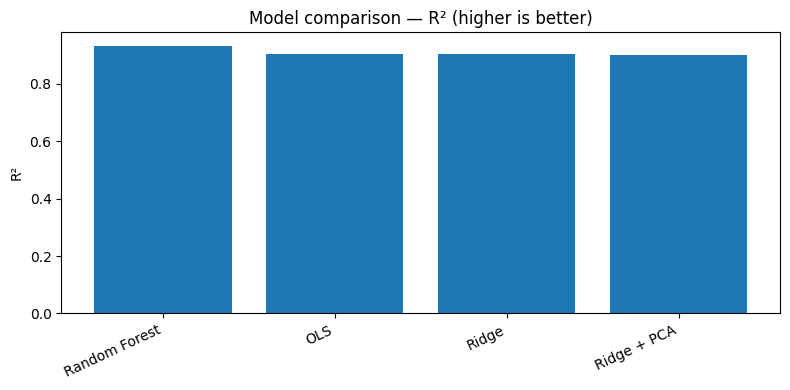

In [8]:
# === Bar chart: R² ===
plt.figure(figsize=(8, 4))
plt.bar(metrics.index, metrics["R2"])
plt.ylabel("R²")
plt.title("Model comparison — R² (higher is better)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


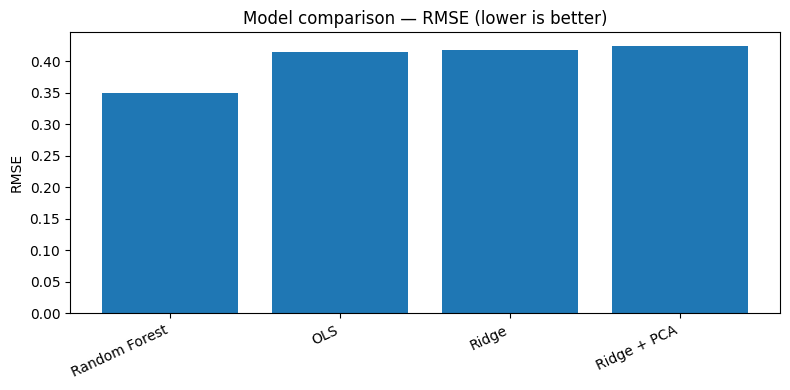

In [9]:
# === Bar chart: RMSE ===
plt.figure(figsize=(8, 4))
plt.bar(metrics.index, metrics["RMSE"])
plt.ylabel("RMSE")
plt.title("Model comparison — RMSE (lower is better)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


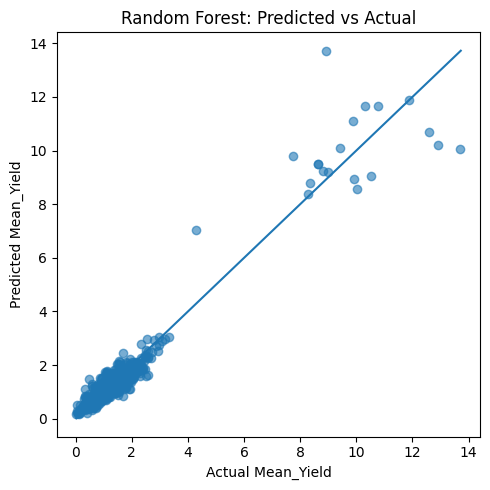

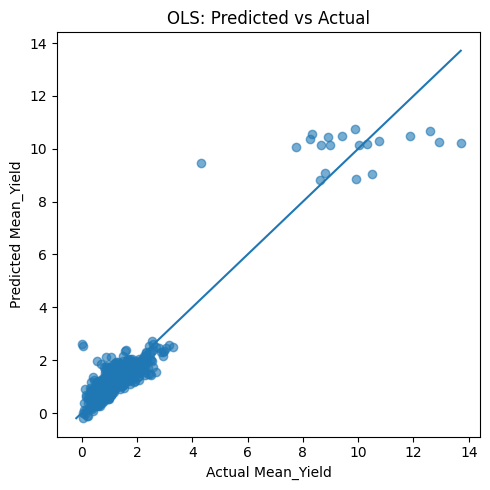

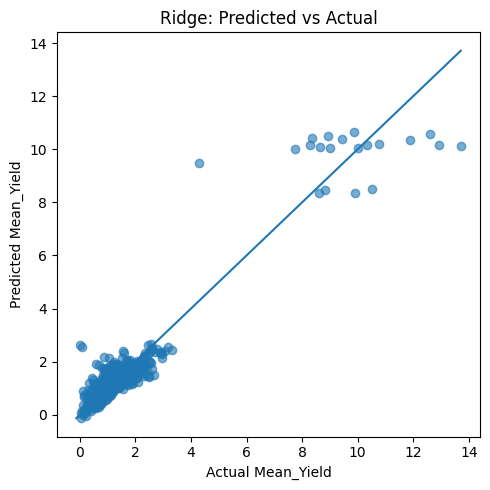

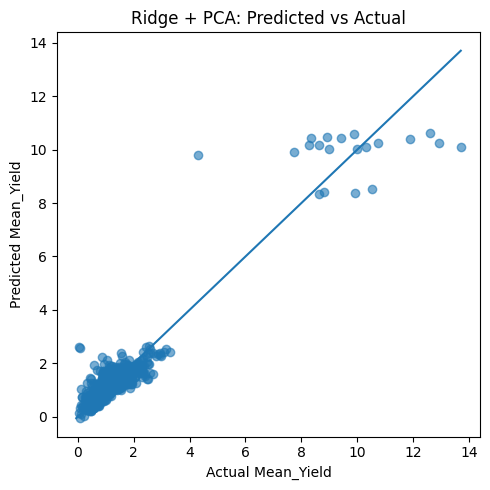

In [10]:
# === Predicted vs Actual (one plot per model) ===

y_true = y_test.values

for name in metrics.index:
    y_pred = results[name]["pred"]

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.6)

    # 45-degree reference line
    lo = float(min(y_true.min(), y_pred.min()))
    hi = float(max(y_true.max(), y_pred.max()))
    plt.plot([lo, hi], [lo, hi])

    plt.xlabel("Actual Mean_Yield")
    plt.ylabel("Predicted Mean_Yield")
    plt.title(f"{name}: Predicted vs Actual")
    plt.tight_layout()
    plt.show()


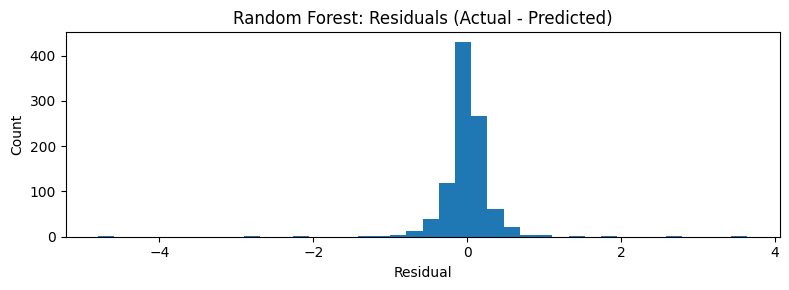

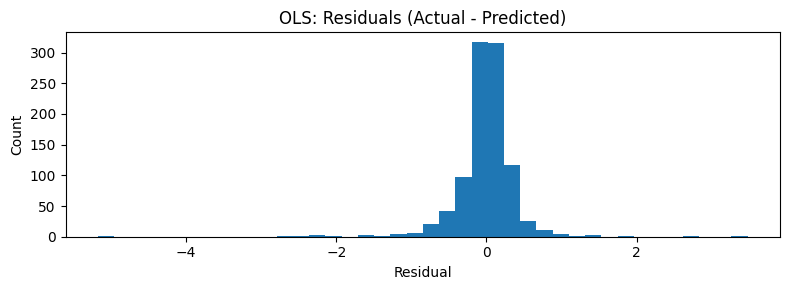

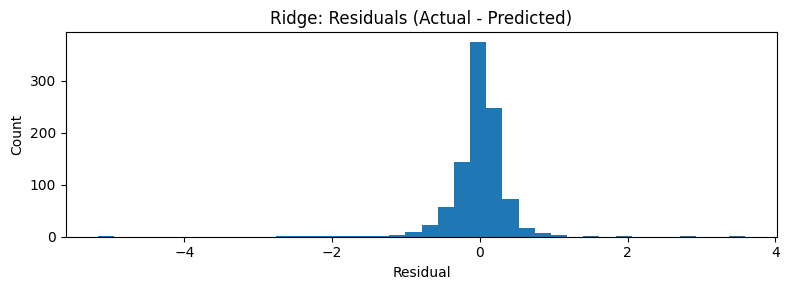

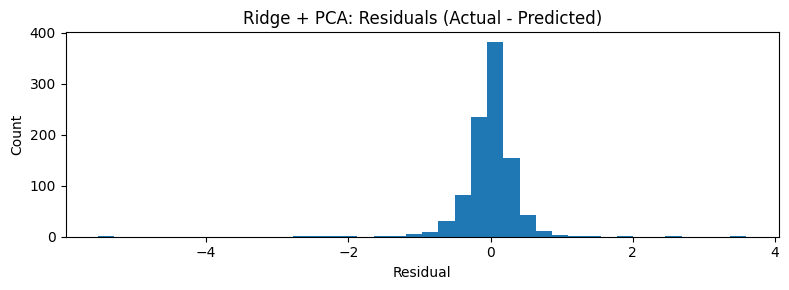

In [11]:
# === (Optional) Residual distribution per model ===
# Useful to see bias and heavy tails.

for name in metrics.index:
    y_pred = results[name]["pred"]
    residuals = y_true - y_pred

    plt.figure(figsize=(8, 3))
    plt.hist(residuals, bins=40)
    plt.title(f"{name}: Residuals (Actual - Predicted)")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## Notes on making this comparison more statistically reliable

If your dataset has strong **time structure** (Year) or **group structure** (Municipality), consider:

- **Split by Year** (train on earlier years, test on later years)
- Or **GroupKFold** cross-validation by Year or Municipality

This helps avoid overly-optimistic scores due to leakage-like effects from random splits.
